In [1]:
#add project directory to python path
import sys
sys.path.append("..")
from default import PROJECT_DIRECTORY, DATA_DIRECTORY
#import standard packages
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function, division
%matplotlib inline

#Adding Scatter to the SMHM in Rank Order SHAM

##Load Simulation

In [2]:
from halotools import sim_manager

#load halo catalogue
simname = 'bolshoi_250'
halocat = sim_manager.CachedHaloCatalog(simname = simname, redshift=0.0, dz_tol = 0.001,
                                        version_name='custom', halo_finder='Rockstar')

#print out column names of halo catalogue
print(halocat.halo_table.dtype.names)

('halo_upid', 'halo_first_acc_mvir', 'halo_acc_scale', 'halo_rvir', 'halo_vpeak', 'halo_macc', 'halo_first_acc_scale', 'halo_mpeak', 'halo_half_mass_scale', 'halo_mvir', 'halo_T/|U|', 'halo_vmax_at_mpeak', 'halo_pid', 'halo_y', 'halo_x', 'halo_z', 'halo_m200b', 'halo_m200c', 'halo_first_acc_vmax', 'halo_mpeak_scale', 'halo_vmax', 'halo_vacc', 'halo_id', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_rs', 'halo_nfw_conc', 'halo_hostid', 'halo_mvir_host_halo')


In [3]:
#define cosmology used in the simulation
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.27) #Bolshoi cosmology
print(cosmo)

FlatLambdaCDM(H0=70 km / (Mpc s), Om0=0.27, Tcmb0=2.725 K, Neff=3.04, m_nu=[ 0.  0.  0.] eV, Ob0=None)


##Rank SHAM with no scatter (RM model)

In [6]:
from halotools.empirical_models import SubhaloModelFactory
from SHAM_model_components import RankSmHm

#build model
prim_haloprop_key = 'halo_mpeak'
mstar_model = RankSmHm(prim_haloprop_key = prim_haloprop_key, Lbox=halocat.Lbox[0], redshift=0.0)
composite_model_1 = SubhaloModelFactory(stellar_mass = mstar_model)

composite_model_1.param_dict['scatter'] = 0.0

#populate simulation
composite_model_1.populate_mock(halocat = halocat)
mock_1 = composite_model_1.mock.galaxy_table
print(mock_1.dtype.names)

('halo_upid', 'halo_hostid', 'halo_mpeak', 'halo_x', 'halo_y', 'halo_id', 'halo_z', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_rvir', 'halo_mvir', 'halo_mvir_host_halo', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'galid', 'stellar_mass')


###Examine SMHM relation

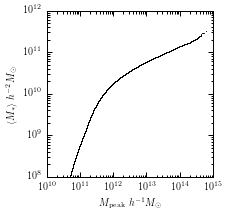

In [7]:
fig = plt.figure(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.plot(mock_1['halo_mpeak'], mock_1['stellar_mass'], '.', color='black', ms=1)
plt.ylim([10**8.0,10**12.0])
plt.xlim([10**10,10**15])
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$M_{\rm peak}~h^{-1}M_{\odot}$')
plt.ylabel(r'$\langle M_{*}\rangle~h^{-2}M_{\odot}$')
plt.show()

##Deconvolve Scatter

In [8]:
from AbundanceMatching import *
from lss_observations.stellar_mass_functions import LiWhite_2009_phi
phi = LiWhite_2009_phi()

In [9]:
#tabulate stellar mass function
msample = np.logspace(5,12,1000)
nsample = phi(msample)
af = AbundanceFunction(np.log10(msample), nsample, faint_end_first=True)

In [10]:
#deconvolution 
scatter = 0.00
remainder = af.deconvolute(scatter, 100)
scatter = 0.05
remainder = af.deconvolute(scatter, 100)
scatter = 0.10
remainder = af.deconvolute(scatter, 100)
scatter = 0.15
remainder = af.deconvolute(scatter, 100)
scatter = 0.20
remainder = af.deconvolute(scatter, 100)
scatter = 0.25
remainder = af.deconvolute(scatter, 100)
scatter = 0.30
remainder = af.deconvolute(scatter, 100)

In [11]:
#build mocks for each of these scatter models
from astropy.table import Table
Nhaloes = len(halocat.halo_table)
arr = np.zeros((Nhaloes,2))
arr[:,0] = halocat.halo_table['halo_mpeak']
mock_1_00 = Table(arr, names=('halo_mpeak', 'stellar_mass'), dtype=('f8', 'f8')) 
mock_1_05 = Table(arr, names=('halo_mpeak', 'stellar_mass'), dtype=('f8', 'f8')) 
mock_1_10 = Table(arr, names=('halo_mpeak', 'stellar_mass'), dtype=('f8', 'f8')) 
mock_1_15 = Table(arr, names=('halo_mpeak', 'stellar_mass'), dtype=('f8', 'f8')) 
mock_1_20 = Table(arr, names=('halo_mpeak', 'stellar_mass'), dtype=('f8', 'f8')) 
mock_1_25 = Table(arr, names=('halo_mpeak', 'stellar_mass'), dtype=('f8', 'f8')) 
mock_1_30 = Table(arr, names=('halo_mpeak', 'stellar_mass'), dtype=('f8', 'f8')) 

In [12]:
nd_halos = calc_number_densities(halocat.halo_table['halo_mpeak'], 250.0)
mock_1_00['stellar_mass'] = 10.0**(af.match(nd_halos, 0.00))
mock_1_05['stellar_mass'] = 10.0**(af.match(nd_halos, 0.05))
mock_1_10['stellar_mass'] = 10.0**(af.match(nd_halos, 0.10))
mock_1_15['stellar_mass'] = 10.0**(af.match(nd_halos, 0.15))
mock_1_20['stellar_mass'] = 10.0**(af.match(nd_halos, 0.20))
mock_1_25['stellar_mass'] = 10.0**(af.match(nd_halos, 0.25))
mock_1_30['stellar_mass'] = 10.0**(af.match(nd_halos, 0.30))

In [13]:
from scipy.stats import binned_statistic
from scipy.stats import linregress

def empirical_SMHM(mstar, mhalo, bins, Nboot=25):
    """
    measure the log mean stellar mass and scatter as a function of halo mass
    """

    x = np.log10(mhalo)
    y = np.log10(mstar)

    bin_centers = (bins[:-1]+bins[1:])/2.0 #log bins
    
    std_y = np.zeros((Nboot, len(bins)-1))
    mean_y = np.zeros((Nboot, len(bins)-1))
    for i in range(0,Nboot):
        boot_inds = np.random.randint(0, len(x), len(x))
        
        xx = x[boot_inds]
        yy = y[boot_inds]
        
        inds = np.digitize(xx, bins=bins)
    
        for j in range(1,len(bins)):
            mask = (inds==j)
            m, b, r, p, e = linregress(xx[mask],yy[mask])
            yyy = yy[mask] - (m*xx[mask] + b) 
            std_y[i,j-1] = np.std(yyy)
            mean_y[i,j-1] = (m*bin_centers[j-1] + b) 
    
    mean_y_err= np.std(mean_y, axis=0)
    mean_y = np.mean(mean_y, axis=0)
    std_y_err = np.std(std_y, axis=0)
    std_y = np.mean(std_y, axis=0)
    
    return bin_centers, mean_y, std_y, mean_y_err, std_y_err

In [14]:
min_m = 11.0
bins = np.arange(min_m,14.5,0.1) #log bins
bin_centers, mean_y_00, std_y_00, mean_y_err_00, std_y_err_00 = empirical_SMHM(mock_1_00['stellar_mass'],
                                                                               mock_1_00['halo_mpeak'], bins)
bin_centers, mean_y_05, std_y_05, mean_y_err_05, std_y_err_05 = empirical_SMHM(mock_1_05['stellar_mass'],
                                                                               mock_1_05['halo_mpeak'], bins)
bin_centers, mean_y_10, std_y_10, mean_y_err_10, std_y_err_10 = empirical_SMHM(mock_1_10['stellar_mass'],
                                                                               mock_1_10['halo_mpeak'], bins)
bin_centers, mean_y_15, std_y_15, mean_y_err_15, std_y_err_15 = empirical_SMHM(mock_1_15['stellar_mass'],
                                                                               mock_1_15['halo_mpeak'], bins)
bin_centers, mean_y_20, std_y_20, mean_y_err_20, std_y_err_20 = empirical_SMHM(mock_1_20['stellar_mass'],
                                                                               mock_1_20['halo_mpeak'], bins)
bin_centers, mean_y_25, std_y_25, mean_y_err_25, std_y_err_25 = empirical_SMHM(mock_1_25['stellar_mass'],
                                                                               mock_1_25['halo_mpeak'], bins)
bin_centers, mean_y_30, std_y_30, mean_y_err_30, std_y_err_30 = empirical_SMHM(mock_1_30['stellar_mass'],
                                                                               mock_1_30['halo_mpeak'], bins)

In [15]:
#get linear errors
err_plus = 10**(mean_y_00 + mean_y_err_00)-10**(mean_y_00)
err_minus = 10**(mean_y_00) - 10**(mean_y_00 - mean_y_err_00)
lin_err_00 = np.vstack((err_minus, err_plus))

err_plus = 10**(mean_y_05 + mean_y_err_05)-10**(mean_y_05)
err_minus = 10**(mean_y_05) - 10**(mean_y_05 - mean_y_err_05)
lin_err_05 = np.vstack((err_minus, err_plus))

err_plus = 10**(mean_y_10 + mean_y_err_10)-10**(mean_y_10)
err_minus = 10**(mean_y_10) - 10**(mean_y_10 - mean_y_err_10)
lin_err_10 = np.vstack((err_minus, err_plus))

err_plus = 10**(mean_y_15 + mean_y_err_15)-10**(mean_y_15)
err_minus = 10**(mean_y_15) - 10**(mean_y_15 - mean_y_err_15)
lin_err_15 = np.vstack((err_minus, err_plus))

err_plus = 10**(mean_y_20 + mean_y_err_20)-10**(mean_y_20)
err_minus = 10**(mean_y_20) - 10**(mean_y_20 - mean_y_err_20)
lin_err_20 = np.vstack((err_minus, err_plus))

err_plus = 10**(mean_y_25 + mean_y_err_25)-10**(mean_y_25)
err_minus = 10**(mean_y_25) - 10**(mean_y_25 - mean_y_err_25)
lin_err_25 = np.vstack((err_minus, err_plus))

err_plus = 10**(mean_y_30 + mean_y_err_30)-10**(mean_y_30)
err_minus = 10**(mean_y_30) - 10**(mean_y_30 - mean_y_err_30)
lin_err_30 = np.vstack((err_minus, err_plus))

In [16]:
"""
fit SMHM relations
"""

from scipy.optimize import curve_fit

#define functional form of the SMHM relation
def broken_powerlaw_model(logx, y0=10.35, x0=11.8, alpha=-0.5, beta=0.65, s=1.0):
    """
    smooth transitioning broken powerlaw model
    """
    y0 = 10.0**y0
    x0 = 10.0**x0
    logx = np.atleast_1d(logx)
    x = 10.0**logx
    return np.log10((2.0*y0/x0)*x*((x/x0)**(alpha) + s*(x/x0)**(beta))**(-1))

#fit model
popt_00, cov = curve_fit(broken_powerlaw_model, bin_centers, mean_y_00,# sigma=mean_y_err,
                      p0=[10.35, 11.8, -0.5, 0.65], bounds=([9.0, 10.0, -2.0, 0.0],[12.0, 13.0, 0.0, 2.0]))
param_err_00 = np.sqrt(cov.diagonal())
print('y0 = {0} +- {1}'.format(popt_00[0],param_err_00[0]))
print('x0 = {0} +- {1}'.format(popt_00[1],param_err_00[1]))
print('alpha = {0} +- {1}'.format(popt_00[2],param_err_00[2]))
print('beta = {0} +- {1}'.format(popt_00[3],param_err_00[3]))
print(' ')
smhm_model_00 = lambda x: 10**broken_powerlaw_model(np.log10(x), *popt_00)

popt_05, cov = curve_fit(broken_powerlaw_model, bin_centers, mean_y_05,# sigma=mean_y_err,
                      p0=[10.35, 11.8, -0.5, 0.65], bounds=([9.0, 10.0, -2.0, 0.0],[12.0, 13.0, 0.0, 2.0]))
param_err_05 = np.sqrt(cov.diagonal())
print('y0 = {0} +- {1}'.format(popt_05[0],param_err_05[0]))
print('x0 = {0} +- {1}'.format(popt_05[1],param_err_05[1]))
print('alpha = {0} +- {1}'.format(popt_05[2],param_err_05[2]))
print('beta = {0} +- {1}'.format(popt_05[3],param_err_05[3]))
print(' ')
smhm_model_05 = lambda x: 10**broken_powerlaw_model(np.log10(x), *popt_05)

popt_10, cov = curve_fit(broken_powerlaw_model, bin_centers, mean_y_10,# sigma=mean_y_err,
                      p0=[10.35, 11.8, -0.5, 0.65], bounds=([9.0, 10.0, -2.0, 0.0],[12.0, 13.0, 0.0, 2.0]))
param_err_10 = np.sqrt(cov.diagonal())
print('y0 = {0} +- {1}'.format(popt_10[0],param_err_10[0]))
print('x0 = {0} +- {1}'.format(popt_10[1],param_err_10[1]))
print('alpha = {0} +- {1}'.format(popt_10[2],param_err_10[2]))
print('beta = {0} +- {1}'.format(popt_10[3],param_err_10[3]))
print(' ')
smhm_model_10 = lambda x: 10**broken_powerlaw_model(np.log10(x), *popt_10)

popt_15, cov = curve_fit(broken_powerlaw_model, bin_centers, mean_y_15,# sigma=mean_y_err,
                      p0=[10.35, 11.8, -0.5, 0.65], bounds=([9.0, 10.0, -2.0, 0.0],[12.0, 13.0, 0.0, 2.0]))
param_err_15 = np.sqrt(cov.diagonal())
print('y0 = {0} +- {1}'.format(popt_15[0],param_err_15[0]))
print('x0 = {0} +- {1}'.format(popt_15[1],param_err_15[1]))
print('alpha = {0} +- {1}'.format(popt_15[2],param_err_15[2]))
print('beta = {0} +- {1}'.format(popt_15[3],param_err_15[3]))
print(' ')
smhm_model_15 = lambda x: 10**broken_powerlaw_model(np.log10(x), *popt_15)

popt_20, cov = curve_fit(broken_powerlaw_model, bin_centers, mean_y_20,# sigma=mean_y_err,
                      p0=[10.35, 11.8, -0.5, 0.65], bounds=([9.0, 10.0, -2.0, 0.0],[12.0, 13.0, 0.0, 2.0]))
param_err_20 = np.sqrt(cov.diagonal())
print('y0 = {0} +- {1}'.format(popt_20[0],param_err_20[0]))
print('x0 = {0} +- {1}'.format(popt_20[1],param_err_20[1]))
print('alpha = {0} +- {1}'.format(popt_20[2],param_err_20[2]))
print('beta = {0} +- {1}'.format(popt_20[3],param_err_20[3]))
print(' ')
smhm_model_20 = lambda x: 10**broken_powerlaw_model(np.log10(x), *popt_20)

popt_25, cov = curve_fit(broken_powerlaw_model, bin_centers, mean_y_25,# sigma=mean_y_err,
                      p0=[10.35, 11.8, -0.5, 0.65], bounds=([9.0, 10.0, -2.0, 0.0],[12.0, 13.0, 0.0, 2.0]))
param_err_25 = np.sqrt(cov.diagonal())
print('y0 = {0} +- {1}'.format(popt_25[0],param_err_25[0]))
print('x0 = {0} +- {1}'.format(popt_25[1],param_err_25[1]))
print('alpha = {0} +- {1}'.format(popt_25[2],param_err_25[2]))
print('beta = {0} +- {1}'.format(popt_25[3],param_err_25[3]))
print(' ')
smhm_model_25 = lambda x: 10**broken_powerlaw_model(np.log10(x), *popt_25)

popt_30, cov = curve_fit(broken_powerlaw_model, bin_centers, mean_y_30,# sigma=mean_y_err,
                      p0=[10.35, 11.8, -0.5, 0.65], bounds=([9.0, 10.0, -2.0, 0.0],[12.0, 13.0, 0.0, 2.0]))
param_err_30 = np.sqrt(cov.diagonal())
print('y0 = {0} +- {1}'.format(popt_30[0],param_err_30[0]))
print('x0 = {0} +- {1}'.format(popt_30[1],param_err_30[1]))
print('alpha = {0} +- {1}'.format(popt_30[2],param_err_30[2]))
print('beta = {0} +- {1}'.format(popt_30[3],param_err_30[3]))
print(' ')
smhm_model_30 = lambda x: 10**broken_powerlaw_model(np.log10(x), *popt_30)

y0 = 9.92265619242 +- 0.0159873400705
x0 = 11.6340578029 +- 0.0156081637263
alpha = -1.16423423877 +- 0.0431282294278
beta = 0.604033719821 +- 0.00561552178369
 
y0 = 9.9232299419 +- 0.0163108395938
x0 = 11.6351232029 +- 0.0159770004945
alpha = -1.16309955629 +- 0.0442071772802
beta = 0.608835797556 +- 0.00576467605772
 
y0 = 9.9309391506 +- 0.0181881994869
x0 = 11.6434828 +- 0.0180626096784
alpha = -1.15037322235 +- 0.0495242453711
beta = 0.626650729986 +- 0.00657545891831
 
y0 = 9.94043796658 +- 0.022554458195
x0 = 11.654762338 +- 0.0228849204398
alpha = -1.13401334813 +- 0.0622584828967
beta = 0.655139374329 +- 0.00845817710262
 
y0 = 9.96286600981 +- 0.0281645291757
x0 = 11.6786212756 +- 0.0296858800697
alpha = -1.09835500922 +- 0.0786459980513
beta = 0.703527430221 +- 0.0112500193025
 
y0 = 9.95477035511 +- 0.0218777539109
x0 = 11.6722812258 +- 0.0236762563397
alpha = -1.13716064775 +- 0.0681021254409
beta = 0.757365811944 +- 0.00940882081065
 
y0 = 10.0219797167 +- 0.022268251532

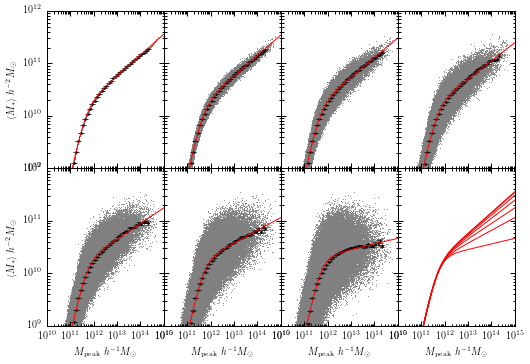

In [19]:
"""
plot the SMHM relations and fits
"""

msample = np.logspace(10,15,1000)

fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(10.0, 5.0))
fig.subplots_adjust(hspace=0, wspace=0, left=0.2, right=0.85, bottom=0.05, top=0.925)
axes = axes.flatten()

ax = axes[0]
ax.plot(mock_1_00['halo_mpeak'], mock_1_00['stellar_mass'], '.', color='grey', ms=1)
ax.errorbar(10**bin_centers, 10**mean_y_00, yerr= lin_err_00, fmt='o', ms=2, color='black')
ax.plot(msample, smhm_model_00(msample), color='red')
ax.set_ylabel(r'$\langle M_{*}\rangle~h^{-2}M_{\odot}$')
ax.set_ylim([10**9.0,10**12.0])
ax.set_xlim([10**10,10**15])
ax.set_xscale('log')
ax.set_yscale('log')

ax = axes[1]
ax.plot(mock_1_05['halo_mpeak'], mock_1_05['stellar_mass'], '.', color='grey', ms=1)
ax.errorbar(10**bin_centers, 10**mean_y_05, yerr= lin_err_05, fmt='o', ms=2, color='black')
ax.plot(msample, smhm_model_05(msample), color='red')
ax.set_ylim([10**9.0,10**12.0])
ax.set_xlim([10**10,10**15])
ax.set_xscale('log')
ax.set_yscale('log')

ax = axes[2]
ax.plot(mock_1_10['halo_mpeak'], mock_1_10['stellar_mass'], '.', color='grey', ms=1)
ax.errorbar(10**bin_centers, 10**mean_y_10, yerr= lin_err_10, fmt='o', ms=2, color='black')
ax.plot(msample, smhm_model_10(msample), color='red')
ax.set_ylim([10**9.0,10**12.0])
ax.set_xlim([10**10,10**15])
ax.set_xscale('log')
ax.set_yscale('log')

ax = axes[3]
ax.plot(mock_1_15['halo_mpeak'], mock_1_15['stellar_mass'], '.', color='grey', ms=1)
ax.errorbar(10**bin_centers, 10**mean_y_15, yerr= lin_err_15, fmt='o', ms=2, color='black')
ax.plot(msample, smhm_model_15(msample), color='red')
ax.set_ylim([10**9.0,10**12.0])
ax.set_xlim([10**10,10**15])
ax.set_xscale('log')
ax.set_yscale('log')

ax = axes[4]
ax.plot(mock_1_00['halo_mpeak'], mock_1_20['stellar_mass'], '.', color='grey', ms=1)
ax.errorbar(10**bin_centers, 10**mean_y_20, yerr= lin_err_20, fmt='o', ms=2, color='black')
ax.plot(msample, smhm_model_20(msample), color='red')
ax.set_ylabel(r'$\langle M_{*}\rangle~h^{-2}M_{\odot}$')
ax.set_xlabel(r'$M_{\rm peak}~h^{-1}M_{\odot}$')
ax.set_ylim([10**9.0,10**12.0])
ax.set_xlim([10**10,10**15])
ax.set_xscale('log')
ax.set_yscale('log')

ax = axes[5]
ax.plot(mock_1_25['halo_mpeak'], mock_1_25['stellar_mass'], '.', color='grey', ms=1)
ax.errorbar(10**bin_centers, 10**mean_y_25, yerr= lin_err_25, fmt='o', ms=2, color='black')
ax.plot(msample, smhm_model_25(msample), color='red')
ax.set_xlabel(r'$M_{\rm peak}~h^{-1}M_{\odot}$')
ax.set_ylim([10**9.0,10**12.0])
ax.set_xlim([10**10,10**15])
ax.set_xscale('log')
ax.set_yscale('log')

ax = axes[6]
ax.plot(mock_1_30['halo_mpeak'], mock_1_30['stellar_mass'], '.', color='grey', ms=1)
ax.errorbar(10**bin_centers, 10**mean_y_30, yerr= lin_err_30, fmt='o', ms=2, color='black')
ax.plot(msample, smhm_model_30(msample), color='red')
ax.set_xlabel(r'$M_{\rm peak}~h^{-1}M_{\odot}$')
ax.set_ylim([10**9.0,10**12.0])
ax.set_xlim([10**10,10**15])
ax.set_xscale('log')
ax.set_yscale('log')

ax = axes[7]
ax.plot(msample, smhm_model_00(msample), color='red')
ax.plot(msample, smhm_model_05(msample), color='red')
ax.plot(msample, smhm_model_10(msample), color='red')
ax.plot(msample, smhm_model_15(msample), color='red')
ax.plot(msample, smhm_model_20(msample), color='red')
ax.plot(msample, smhm_model_25(msample), color='red')
ax.plot(msample, smhm_model_30(msample), color='red')
ax.set_ylim([10**9.0,10**12.0])
ax.set_xlim([10**10,10**15])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$M_{\rm peak}~h^{-1}M_{\odot}$')
plt.show()

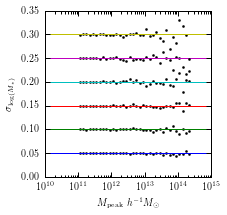

In [21]:
fig = plt.figure(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.errorbar(10**bin_centers, std_y_05, fmt='o', ms=2, color='black')
plt.plot([10**10,10**15],[0.05,0.05],'-')
plt.errorbar(10**bin_centers, std_y_10, fmt='o', ms=2, color='black')
plt.plot([10**10,10**15],[0.1,0.1],'-')
plt.errorbar(10**bin_centers, std_y_15, fmt='o', ms=2, color='black')
plt.plot([10**10,10**15],[0.15,0.15],'-')
plt.errorbar(10**bin_centers, std_y_20, fmt='o', ms=2, color='black')
plt.plot([10**10,10**15],[0.2,0.2],'-')
plt.errorbar(10**bin_centers, std_y_25, fmt='o', ms=2, color='black')
plt.plot([10**10,10**15],[0.25,0.25],'-')
plt.errorbar(10**bin_centers, std_y_30, fmt='o', ms=2, color='black')
plt.plot([10**10,10**15],[0.3,0.3],'-')
plt.ylim([0,0.35])
plt.xlim([10**10,10**15])
plt.xscale('log')
plt.xlabel(r'$M_{\rm peak}~h^{-1}M_{\odot}$')
plt.ylabel(r'$\sigma_{\log(M_*)}$')
plt.show()

In [20]:
sigmas = np.array([0,0.05,0.1,0.15,0.2,0.25,0.3])
y0s = np.array([popt_00[0],popt_05[0],popt_10[0],popt_15[0],popt_20[0],popt_25[0],popt_30[0]])
x0s = np.array([popt_00[1],popt_05[1],popt_10[1],popt_15[1],popt_20[1],popt_25[1],popt_30[1]])
alphas = np.array([popt_00[2],popt_05[2],popt_10[2],popt_15[2],popt_20[2],popt_25[2],popt_30[2]])
betas = np.array([popt_00[3],popt_05[3],popt_10[3],popt_15[3],popt_20[3],popt_25[3],popt_30[3]])

y0s_err = np.array([param_err_00[0],param_err_05[0],param_err_10[0],param_err_15[0],param_err_20[0],param_err_25[0],param_err_30[0]])
x0s_err = np.array([param_err_00[1],param_err_05[1],param_err_10[1],param_err_15[1],param_err_20[1],param_err_25[1],param_err_30[1]])
alphas_err  = np.array([param_err_00[2],param_err_05[2],param_err_10[2],param_err_15[2],param_err_20[2],param_err_25[2],param_err_30[2]])
betas_err  = np.array([param_err_00[3],param_err_05[3],param_err_10[3],param_err_15[3],param_err_20[3],param_err_25[3],param_err_30[3]])

x0 = 0.547472350363 +- 0.122298527126
alpha = 4.05503561022 +- 1.45090602182
b = 8.92667912101 +- 0.00536398171368
 


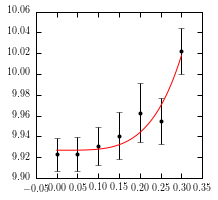

In [21]:
def exp_model(x, x0=0.5, alpha=1.5, b=-1.2, a=1.0):
    return a*np.exp((x/x0)**alpha) + b

popt_1, cov = curve_fit(exp_model, sigmas, y0s, sigma=y0s_err, p0=[0.5,1.5,10.0])
param_err = np.sqrt(cov.diagonal())
print('x0 = {0} +- {1}'.format(popt_1[0],param_err[0]))
print('alpha = {0} +- {1}'.format(popt_1[1],param_err[1]))
print('b = {0} +- {1}'.format(popt_1[2],param_err[2]))
#print('a = {0} +- {1}'.format(popt[3],param_err[3]))
print(' ')

y0_model = lambda x: exp_model(x, *popt_1)

x_sample = np.linspace(0,0.3,100)

fig = plt.figure(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.errorbar(sigmas, y0s, yerr=y0s_err, fmt='o', mec='none', color='black', ms=4)
plt.plot(x_sample, y0_model(x_sample), '-', color='red')
plt.xlim([-0.05,0.35])
plt.show()

x0 = 0.703187593335 +- 0.213858208563
alpha = 2.85546518299 +- 0.968017598035
b = 10.6364794467 +- 0.00540108352041
 


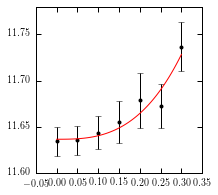

In [22]:
def exp_model(x, x0=0.5, alpha=1.5, b=-1.2, a=1.0):
    return a*np.exp((x/x0)**alpha) + b

popt_2, cov = curve_fit(exp_model, sigmas, x0s, sigma=x0s_err, p0=[0.5,1.5,2.0])
param_err = np.sqrt(cov.diagonal())
print('x0 = {0} +- {1}'.format(popt_2[0],param_err[0]))
print('alpha = {0} +- {1}'.format(popt_2[1],param_err[1]))
print('b = {0} +- {1}'.format(popt_2[2],param_err[2]))
#print('a = {0} +- {1}'.format(popt[3],param_err[3]))
print(' ')

x0_model = lambda x: exp_model(x, *popt_2)

x_sample = np.linspace(0,0.3,100)

fig = plt.figure(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.errorbar(sigmas, x0s, yerr=x0s_err, fmt='o', mec='none', color='black', ms=4)
plt.plot(x_sample, x0_model(x_sample), '-', color='red')
plt.xlim([-0.05,0.35])
plt.show()

x0 = 1.01696154569 +- 0.775573640499
alpha = 1.98272814054 +- 1.19074537029
b = -2.16313857808 +- 0.0118438147045
 


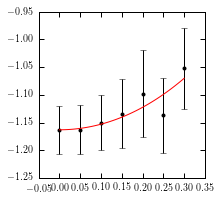

In [23]:
def exp_model(x, x0=0.5, alpha=1.5, b=-1.2, a=1.0):
    return a*np.exp((x/x0)**alpha) + b

popt_3, cov = curve_fit(exp_model, sigmas, alphas, sigma=alphas_err, p0=[0.5,1.5,-4.5])
param_err = np.sqrt(cov.diagonal())
print('x0 = {0} +- {1}'.format(popt_3[0],param_err[0]))
print('alpha = {0} +- {1}'.format(popt_3[1],param_err[1]))
print('b = {0} +- {1}'.format(popt_3[2],param_err[2]))
#print('a = {0} +- {1}'.format(popt[3],param_err[3]))
print(' ')

alpha_model = lambda x: exp_model(x, *popt_3)

x_sample = np.linspace(0,0.3,100)

fig = plt.figure(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.errorbar(sigmas, alphas, yerr=alphas_err, fmt='o', mec='none', color='black', ms=4)
plt.plot(x_sample, alpha_model(x_sample), '-', color='red')
plt.xlim([-0.05,0.35])
plt.show()

x0 = 0.519439295849 +- 0.0305282867378
alpha = 2.56341443038 +- 0.246004301463
b = -0.392774911114 +- 0.00447839184784
 


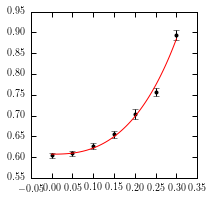

In [24]:
def exp_model(x, x0=0.5, alpha=1.5, b=-1.2, a=1.0):
    return a*np.exp((x/x0)**alpha) + b

popt_4, cov = curve_fit(exp_model, sigmas, betas, sigma=betas_err, p0=[0.5,1.5,-1.2])
param_err = np.sqrt(cov.diagonal())
print('x0 = {0} +- {1}'.format(popt_4[0],param_err[0]))
print('alpha = {0} +- {1}'.format(popt_4[1],param_err[1]))
print('b = {0} +- {1}'.format(popt_4[2],param_err[2]))
#print('a = {0} +- {1}'.format(popt[3],param_err[3]))
print(' ')

beta_model = lambda x: exp_model(x, *popt_4)

x_sample = np.linspace(0,0.3,100)

fig = plt.figure(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.errorbar(sigmas, betas, yerr=betas_err, fmt='o', mec='none', color='black', ms=4)
plt.plot(x_sample, beta_model(x_sample), '-', color='red')
plt.xlim([-0.05,0.35])
plt.show()

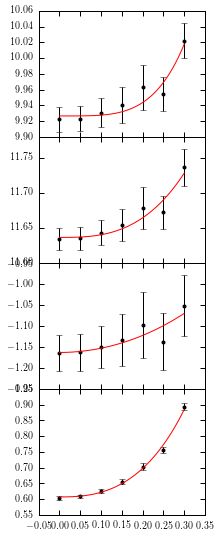

In [25]:
fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(3.3, 10.0))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.1, top=0.95, hspace=0.0)

#top panel
ax=axes[0]
ax.errorbar(sigmas, y0s, yerr=y0s_err, fmt='o', mec='none', color='black', ms=4)
ax.plot(x_sample, y0_model(x_sample), '-', color='red')
ax.set_xlim([-0.05,0.35])

#upper middle
ax=axes[1]
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
ax.errorbar(sigmas, x0s, yerr=x0s_err, fmt='o', mec='none', color='black', ms=4)
ax.plot(x_sample, x0_model(x_sample), '-', color='red')
ax.set_xlim([-0.05,0.35])

#lower middle
ax=axes[2]
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
ax.errorbar(sigmas, alphas, yerr=alphas_err, fmt='o', mec='none', color='black', ms=4)
ax.plot(x_sample, alpha_model(x_sample), '-', color='red')
ax.set_xlim([-0.05,0.35])

#bottom panel
ax=axes[3]
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
ax.errorbar(sigmas, betas, yerr=betas_err, fmt='o', mec='none', color='black', ms=4)
ax.plot(x_sample, beta_model(x_sample), '-', color='red')
ax.set_xlim([-0.05,0.35])

plt.show()

In [26]:
from SHAM_model_components import ParamSmHm
smhm = ParamSmHm(prim_haloprop_key='halo_mpeak', scatter=0.0)

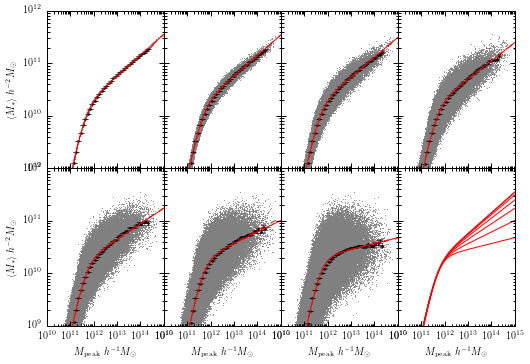

In [31]:
"""
plot the SMHM relations and fits
"""

msample = np.logspace(10,15,1000)

fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(10.0, 5.0))
fig.subplots_adjust(hspace=0, wspace=0, left=0.2, right=0.85, bottom=0.05, top=0.925)
axes = axes.flatten()

ax = axes[0]
ax.plot(mock_1_00['halo_mpeak'], mock_1_00['stellar_mass'], '.', color='grey', ms=1)
ax.errorbar(10**bin_centers, 10**mean_y_00, yerr= lin_err_00, fmt='o', ms=2, color='black')
ax.plot(msample, smhm_model_00(msample), '--', color='red')
smhm = ParamSmHm(prim_haloprop_key='halo_mpeak', log_scatter=0.0)
ax.plot(msample, smhm.mean_stellar_mass(prim_haloprop=msample), '-', color='red')
ax.set_ylabel(r'$\langle M_{*}\rangle~h^{-2}M_{\odot}$')
ax.set_ylim([10**9.0,10**12.0])
ax.set_xlim([10**10,10**15])
ax.set_xscale('log')
ax.set_yscale('log')

ax = axes[1]
ax.plot(mock_1_05['halo_mpeak'], mock_1_05['stellar_mass'], '.', color='grey', ms=1)
ax.errorbar(10**bin_centers, 10**mean_y_05, yerr= lin_err_05, fmt='o', ms=2, color='black')
ax.plot(msample, smhm_model_05(msample), '--', color='red')
smhm = ParamSmHm(prim_haloprop_key='halo_mpeak', log_scatter=0.05)
ax.plot(msample, smhm.mean_stellar_mass(prim_haloprop=msample), '-', color='red')
ax.set_ylim([10**9.0,10**12.0])
ax.set_xlim([10**10,10**15])
ax.set_xscale('log')
ax.set_yscale('log')

ax = axes[2]
ax.plot(mock_1_10['halo_mpeak'], mock_1_10['stellar_mass'], '.', color='grey', ms=1)
ax.errorbar(10**bin_centers, 10**mean_y_10, yerr= lin_err_10, fmt='o', ms=2, color='black')
ax.plot(msample, smhm_model_10(msample),  '--',color='red')
smhm = ParamSmHm(prim_haloprop_key='halo_mpeak', log_scatter=0.1)
ax.plot(msample, smhm.mean_stellar_mass(prim_haloprop=msample), '-', color='red')
ax.set_ylim([10**9.0,10**12.0])
ax.set_xlim([10**10,10**15])
ax.set_xscale('log')
ax.set_yscale('log')

ax = axes[3]
ax.plot(mock_1_15['halo_mpeak'], mock_1_15['stellar_mass'], '.', color='grey', ms=1)
ax.errorbar(10**bin_centers, 10**mean_y_15, yerr= lin_err_15, fmt='o', ms=2, color='black')
ax.plot(msample, smhm_model_15(msample),  '--',color='red')
smhm = ParamSmHm(prim_haloprop_key='halo_mpeak', log_scatter=0.15)
ax.plot(msample, smhm.mean_stellar_mass(prim_haloprop=msample), '-', color='red')
ax.set_ylim([10**9.0,10**12.0])
ax.set_xlim([10**10,10**15])
ax.set_xscale('log')
ax.set_yscale('log')

ax = axes[4]
ax.plot(mock_1_00['halo_mpeak'], mock_1_20['stellar_mass'], '.', color='grey', ms=1)
ax.errorbar(10**bin_centers, 10**mean_y_20, yerr= lin_err_20, fmt='o', ms=2, color='black')
ax.plot(msample, smhm_model_20(msample), '--', color='red')
smhm = ParamSmHm(prim_haloprop_key='halo_mpeak', log_scatter=0.2)
ax.plot(msample, smhm.mean_stellar_mass(prim_haloprop=msample), '-', color='red')
ax.set_ylabel(r'$\langle M_{*}\rangle~h^{-2}M_{\odot}$')
ax.set_xlabel(r'$M_{\rm peak}~h^{-1}M_{\odot}$')
ax.set_ylim([10**9.0,10**12.0])
ax.set_xlim([10**10,10**15])
ax.set_xscale('log')
ax.set_yscale('log')

ax = axes[5]
ax.plot(mock_1_25['halo_mpeak'], mock_1_25['stellar_mass'], '.', color='grey', ms=1)
ax.errorbar(10**bin_centers, 10**mean_y_25, yerr= lin_err_25, fmt='o', ms=2, color='black')
ax.plot(msample, smhm_model_25(msample), '--', color='red')
smhm = ParamSmHm(prim_haloprop_key='halo_mpeak', log_scatter=0.25)
ax.plot(msample, smhm.mean_stellar_mass(prim_haloprop=msample), '-', color='red')
ax.set_xlabel(r'$M_{\rm peak}~h^{-1}M_{\odot}$')
ax.set_ylim([10**9.0,10**12.0])
ax.set_xlim([10**10,10**15])
ax.set_xscale('log')
ax.set_yscale('log')

ax = axes[6]
ax.plot(mock_1_30['halo_mpeak'], mock_1_30['stellar_mass'], '.', color='grey', ms=1)
ax.errorbar(10**bin_centers, 10**mean_y_30, yerr= lin_err_30, fmt='o', ms=2, color='black')
ax.plot(msample, smhm_model_30(msample), '--', color='red')
smhm = ParamSmHm(prim_haloprop_key='halo_mpeak', log_scatter=0.30)
ax.plot(msample, smhm.mean_stellar_mass(prim_haloprop=msample), '-', color='red')
ax.set_xlabel(r'$M_{\rm peak}~h^{-1}M_{\odot}$')
ax.set_ylim([10**9.0,10**12.0])
ax.set_xlim([10**10,10**15])
ax.set_xscale('log')
ax.set_yscale('log')

ax = axes[7]
smhm = ParamSmHm(prim_haloprop_key='halo_mpeak', log_scatter=0.0)
ax.plot(msample, smhm.mean_stellar_mass(prim_haloprop=msample), '-', color='red')
smhm = ParamSmHm(prim_haloprop_key='halo_mpeak', log_scatter=0.05)
ax.plot(msample, smhm.mean_stellar_mass(prim_haloprop=msample), '-', color='red')
smhm = ParamSmHm(prim_haloprop_key='halo_mpeak', log_scatter=0.1)
ax.plot(msample, smhm.mean_stellar_mass(prim_haloprop=msample), '-', color='red')
smhm = ParamSmHm(prim_haloprop_key='halo_mpeak', log_scatter=0.15)
ax.plot(msample, smhm.mean_stellar_mass(prim_haloprop=msample), '-', color='red')
smhm = ParamSmHm(prim_haloprop_key='halo_mpeak', log_scatter=0.2)
ax.plot(msample, smhm.mean_stellar_mass(prim_haloprop=msample), '-', color='red')
smhm = ParamSmHm(prim_haloprop_key='halo_mpeak', log_scatter=0.25)
ax.plot(msample, smhm.mean_stellar_mass(prim_haloprop=msample), '-', color='red')
smhm = ParamSmHm(prim_haloprop_key='halo_mpeak', log_scatter=0.3)
ax.plot(msample, smhm.mean_stellar_mass(prim_haloprop=msample), '-', color='red')
ax.set_ylim([10**9.0,10**12.0])
ax.set_xlim([10**10,10**15])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$M_{\rm peak}~h^{-1}M_{\odot}$')
plt.show()

##Rank SHAM with no scatter (RV)

In [32]:
from halotools.empirical_models import SubhaloModelFactory
from SHAM_model_components import RankSmHm

#build model
prim_haloprop_key = 'halo_vpeak'
mstar_model = RankSmHm(prim_haloprop_key = prim_haloprop_key, Lbox=halocat.Lbox[0], redshift=0.0)
composite_model_2 = SubhaloModelFactory(stellar_mass = mstar_model)

composite_model_2.param_dict['scatter'] = 0.0

#populate simulation
composite_model_2.populate_mock(halocat = halocat)
mock_2 = composite_model_2.mock.galaxy_table
print(mock_2.dtype.names)

('halo_upid', 'halo_hostid', 'halo_x', 'halo_y', 'halo_id', 'halo_z', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_rvir', 'halo_vpeak', 'halo_mvir', 'halo_mvir_host_halo', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'galid', 'stellar_mass')


###Examine SMVP Relation

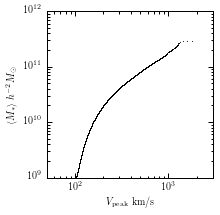

In [33]:
fig = plt.figure(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.plot(mock_2['halo_vpeak'], mock_2['stellar_mass'], '.', color='black', ms=1)
plt.xlim([50,3000])
plt.ylim([10**9,10**12])
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$V_{\rm peak}~{\rm km/s}$')
plt.ylabel(r'$\langle M_{*}\rangle~h^{-2}M_{\odot}$')
plt.show()

###Deconvolve Scatter

In [4]:
from AbundanceMatching import *
from lss_observations.stellar_mass_functions import LiWhite_2009_phi
phi = LiWhite_2009_phi()

In [5]:
#tabulate stellar mass function
msample = np.logspace(5,12,1000)
nsample = phi(msample)
af = AbundanceFunction(np.log10(msample), nsample, faint_end_first=True)

In [7]:
#deconvolution 
scatter = 0.00
remainder = af.deconvolute(scatter, 100)
scatter = 0.05
remainder = af.deconvolute(scatter, 100)
scatter = 0.10
remainder = af.deconvolute(scatter, 100)
scatter = 0.15
remainder = af.deconvolute(scatter, 100)
scatter = 0.20
remainder = af.deconvolute(scatter, 100)
scatter = 0.25
remainder = af.deconvolute(scatter, 100)
scatter = 0.30
remainder = af.deconvolute(scatter, 100)

In [8]:
#build mocks for each of these scatter models
from astropy.table import Table
Nhaloes = len(halocat.halo_table)
arr = np.zeros((Nhaloes,2))
arr[:,0] = halocat.halo_table['halo_vpeak']
mock_2_00 = Table(arr, names=('halo_vpeak', 'stellar_mass'), dtype=('f8', 'f8')) 
mock_2_05 = Table(arr, names=('halo_vpeak', 'stellar_mass'), dtype=('f8', 'f8')) 
mock_2_10 = Table(arr, names=('halo_vpeak', 'stellar_mass'), dtype=('f8', 'f8')) 
mock_2_15 = Table(arr, names=('halo_vpeak', 'stellar_mass'), dtype=('f8', 'f8')) 
mock_2_20 = Table(arr, names=('halo_vpeak', 'stellar_mass'), dtype=('f8', 'f8')) 
mock_2_25 = Table(arr, names=('halo_vpeak', 'stellar_mass'), dtype=('f8', 'f8')) 
mock_2_30 = Table(arr, names=('halo_vpeak', 'stellar_mass'), dtype=('f8', 'f8')) 

In [9]:
nd_halos = calc_number_densities(halocat.halo_table['halo_vpeak'], 250.0)
mock_2_00['stellar_mass'] = 10.0**(af.match(nd_halos, 0.00))
mock_2_05['stellar_mass'] = 10.0**(af.match(nd_halos, 0.05))
mock_2_10['stellar_mass'] = 10.0**(af.match(nd_halos, 0.10))
mock_2_15['stellar_mass'] = 10.0**(af.match(nd_halos, 0.15))
mock_2_20['stellar_mass'] = 10.0**(af.match(nd_halos, 0.20))
mock_2_25['stellar_mass'] = 10.0**(af.match(nd_halos, 0.25))
mock_2_30['stellar_mass'] = 10.0**(af.match(nd_halos, 0.30))

In [10]:
from scipy.stats import binned_statistic
from scipy.stats import linregress

def empirical_SMHM(mstar, mhalo, bins, Nboot=25):
    """
    measure the log mean stellar mass and scatter as a function of halo mass
    """

    x = np.log10(mhalo)
    y = np.log10(mstar)

    bin_centers = (bins[:-1]+bins[1:])/2.0 #log bins
    
    std_y = np.zeros((Nboot, len(bins)-1))
    mean_y = np.zeros((Nboot, len(bins)-1))
    for i in range(0,Nboot):
        boot_inds = np.random.randint(0, len(x), len(x))
        
        xx = x[boot_inds]
        yy = y[boot_inds]
        
        inds = np.digitize(xx, bins=bins)
    
        for j in range(1,len(bins)):
            mask = (inds==j)
            m, b, r, p, e = linregress(xx[mask],yy[mask])
            yyy = yy[mask] - (m*xx[mask] + b) 
            std_y[i,j-1] = np.std(yyy)
            mean_y[i,j-1] = (m*bin_centers[j-1] + b) 
    
    mean_y_err= np.std(mean_y, axis=0)
    mean_y = np.mean(mean_y, axis=0)
    std_y_err = np.std(std_y, axis=0)
    std_y = np.mean(std_y, axis=0)
    
    return bin_centers, mean_y, std_y, mean_y_err, std_y_err

In [11]:
min_v = 2.0
bins = np.arange(min_v,3.1,0.025) #log bins

bin_centers, mean_y_00, std_y_00, mean_y_err_00, std_y_err_00 = empirical_SMHM(mock_2_00['stellar_mass'],
                                                                               mock_2_00['halo_vpeak'], bins)
bin_centers, mean_y_05, std_y_05, mean_y_err_05, std_y_err_05 = empirical_SMHM(mock_2_05['stellar_mass'],
                                                                               mock_2_05['halo_vpeak'], bins)
bin_centers, mean_y_10, std_y_10, mean_y_err_10, std_y_err_10 = empirical_SMHM(mock_2_10['stellar_mass'],
                                                                               mock_2_10['halo_vpeak'], bins)
bin_centers, mean_y_15, std_y_15, mean_y_err_15, std_y_err_15 = empirical_SMHM(mock_2_15['stellar_mass'],
                                                                               mock_2_15['halo_vpeak'], bins)
bin_centers, mean_y_20, std_y_20, mean_y_err_20, std_y_err_20 = empirical_SMHM(mock_2_20['stellar_mass'],
                                                                               mock_2_20['halo_vpeak'], bins)
bin_centers, mean_y_25, std_y_25, mean_y_err_25, std_y_err_25 = empirical_SMHM(mock_2_25['stellar_mass'],
                                                                               mock_2_25['halo_vpeak'], bins)
bin_centers, mean_y_30, std_y_30, mean_y_err_30, std_y_err_30 = empirical_SMHM(mock_2_30['stellar_mass'],
                                                                               mock_2_30['halo_vpeak'], bins)

In [12]:
#get linear errors
err_plus = 10**(mean_y_00 + mean_y_err_00)-10**(mean_y_00)
err_minus = 10**(mean_y_00) - 10**(mean_y_00 - mean_y_err_00)
lin_err_00 = np.vstack((err_minus, err_plus))

err_plus = 10**(mean_y_05 + mean_y_err_05)-10**(mean_y_05)
err_minus = 10**(mean_y_05) - 10**(mean_y_05 - mean_y_err_05)
lin_err_05 = np.vstack((err_minus, err_plus))

err_plus = 10**(mean_y_10 + mean_y_err_10)-10**(mean_y_10)
err_minus = 10**(mean_y_10) - 10**(mean_y_10 - mean_y_err_10)
lin_err_10 = np.vstack((err_minus, err_plus))

err_plus = 10**(mean_y_15 + mean_y_err_15)-10**(mean_y_15)
err_minus = 10**(mean_y_15) - 10**(mean_y_15 - mean_y_err_15)
lin_err_15 = np.vstack((err_minus, err_plus))

err_plus = 10**(mean_y_20 + mean_y_err_20)-10**(mean_y_20)
err_minus = 10**(mean_y_20) - 10**(mean_y_20 - mean_y_err_20)
lin_err_20 = np.vstack((err_minus, err_plus))

err_plus = 10**(mean_y_25 + mean_y_err_25)-10**(mean_y_25)
err_minus = 10**(mean_y_25) - 10**(mean_y_25 - mean_y_err_25)
lin_err_25 = np.vstack((err_minus, err_plus))

err_plus = 10**(mean_y_30 + mean_y_err_30)-10**(mean_y_30)
err_minus = 10**(mean_y_30) - 10**(mean_y_30 - mean_y_err_30)
lin_err_30 = np.vstack((err_minus, err_plus))

In [13]:
"""
fit SMHM relations
"""

from scipy.optimize import curve_fit

#define functional form of the SMHM relation
def broken_powerlaw_model(logx, y0=10.35, x0=11.8, alpha=-0.5, beta=0.65, s=1.0):
    """
    smooth transitioning broken powerlaw model
    """
    y0 = 10.0**y0
    x0 = 10.0**x0
    logx = np.atleast_1d(logx)
    x = 10.0**logx
    return np.log10((2.0*y0/x0)*x*((x/x0)**(alpha) + s*(x/x0)**(beta))**(-1))

#fit model
popt_00, cov = curve_fit(broken_powerlaw_model, bin_centers, mean_y_00,# sigma=mean_y_err,
                         p0=[10.0, 2.2, -5, 0.2], bounds=([9.0,0.0,-10.0,-1.0],[10.0,3.0,0.0,2]))
param_err_00 = np.sqrt(cov.diagonal())
print('y0 = {0} +- {1}'.format(popt_00[0],param_err_00[0]))
print('x0 = {0} +- {1}'.format(popt_00[1],param_err_00[1]))
print('alpha = {0} +- {1}'.format(popt_00[2],param_err_00[2]))
print('beta = {0} +- {1}'.format(popt_00[3],param_err_00[3]))
print(' ')
smhm_model_00 = lambda x: 10**broken_powerlaw_model(np.log10(x), *popt_00)

popt_05, cov = curve_fit(broken_powerlaw_model, bin_centers, mean_y_05,# sigma=mean_y_err,
                         p0=[10.0, 2.2, -5, 0.2], bounds=([9.0,0.0,-10.0,-1.0],[10.0,3.0,0.0,2]))
param_err_05 = np.sqrt(cov.diagonal())
print('y0 = {0} +- {1}'.format(popt_05[0],param_err_05[0]))
print('x0 = {0} +- {1}'.format(popt_05[1],param_err_05[1]))
print('alpha = {0} +- {1}'.format(popt_05[2],param_err_05[2]))
print('beta = {0} +- {1}'.format(popt_05[3],param_err_05[3]))
print(' ')
smhm_model_05 = lambda x: 10**broken_powerlaw_model(np.log10(x), *popt_05)

popt_10, cov = curve_fit(broken_powerlaw_model, bin_centers, mean_y_10,# sigma=mean_y_err,
                         p0=[10.0, 2.2, -5, 0.2], bounds=([9.0,0.0,-10.0,-1.0],[10.0,3.0,0.0,2]))
param_err_10 = np.sqrt(cov.diagonal())
print('y0 = {0} +- {1}'.format(popt_10[0],param_err_10[0]))
print('x0 = {0} +- {1}'.format(popt_10[1],param_err_10[1]))
print('alpha = {0} +- {1}'.format(popt_10[2],param_err_10[2]))
print('beta = {0} +- {1}'.format(popt_10[3],param_err_10[3]))
print(' ')
smhm_model_10 = lambda x: 10**broken_powerlaw_model(np.log10(x), *popt_10)

popt_15, cov = curve_fit(broken_powerlaw_model, bin_centers, mean_y_15,# sigma=mean_y_err,
                         p0=[10.0, 2.2, -5, 0.2], bounds=([9.0,0.0,-10.0,-1.0],[10.0,3.0,0.0,2]))
param_err_15 = np.sqrt(cov.diagonal())
print('y0 = {0} +- {1}'.format(popt_15[0],param_err_15[0]))
print('x0 = {0} +- {1}'.format(popt_15[1],param_err_15[1]))
print('alpha = {0} +- {1}'.format(popt_15[2],param_err_15[2]))
print('beta = {0} +- {1}'.format(popt_15[3],param_err_15[3]))
print(' ')
smhm_model_15 = lambda x: 10**broken_powerlaw_model(np.log10(x), *popt_15)

popt_20, cov = curve_fit(broken_powerlaw_model, bin_centers, mean_y_20,# sigma=mean_y_err,
                         p0=[10.0, 2.2, -5, 0.2], bounds=([9.0,0.0,-10.0,-1.0],[10.0,3.0,0.0,2]))
param_err_20 = np.sqrt(cov.diagonal())
print('y0 = {0} +- {1}'.format(popt_20[0],param_err_20[0]))
print('x0 = {0} +- {1}'.format(popt_20[1],param_err_20[1]))
print('alpha = {0} +- {1}'.format(popt_20[2],param_err_20[2]))
print('beta = {0} +- {1}'.format(popt_20[3],param_err_20[3]))
print(' ')
smhm_model_20 = lambda x: 10**broken_powerlaw_model(np.log10(x), *popt_20)

popt_25, cov = curve_fit(broken_powerlaw_model, bin_centers, mean_y_25,# sigma=mean_y_err,
                         p0=[10.0, 2.2, -5, 0.2], bounds=([9.0,0.0,-10.0,-1.0],[10.0,3.0,0.0,2]))
param_err_25 = np.sqrt(cov.diagonal())
print('y0 = {0} +- {1}'.format(popt_25[0],param_err_25[0]))
print('x0 = {0} +- {1}'.format(popt_25[1],param_err_25[1]))
print('alpha = {0} +- {1}'.format(popt_25[2],param_err_25[2]))
print('beta = {0} +- {1}'.format(popt_25[3],param_err_25[3]))
print(' ')
smhm_model_25 = lambda x: 10**broken_powerlaw_model(np.log10(x), *popt_25)

popt_30, cov = curve_fit(broken_powerlaw_model, bin_centers, mean_y_30,# sigma=mean_y_err,
                         p0=[10.0, 2.2, -5, 0.2], bounds=([9.0,0.0,-10.0,-1.0],[10.0,3.0,0.0,2]))
param_err_30 = np.sqrt(cov.diagonal())
print('y0 = {0} +- {1}'.format(popt_30[0],param_err_30[0]))
print('x0 = {0} +- {1}'.format(popt_30[1],param_err_30[1]))
print('alpha = {0} +- {1}'.format(popt_30[2],param_err_30[2]))
print('beta = {0} +- {1}'.format(popt_30[3],param_err_30[3]))
print(' ')
smhm_model_30 = lambda x: 10**broken_powerlaw_model(np.log10(x), *popt_30)

y0 = 9.9464674072 +- 0.0148431467008
x0 = 2.17757979054 +- 0.00459800084201
alpha = -5.94908713728 +- 0.147234264006
beta = -0.255634156676 +- 0.0160360129544
 
y0 = 9.94424827014 +- 0.015591920312
x0 = 2.17715272137 +- 0.0048382701832
alpha = -5.96290072243 +- 0.156331746237
beta = -0.244080722588 +- 0.0169313309571
 
y0 = 9.94494156384 +- 0.0157629972458
x0 = 2.17784917628 +- 0.00494153509537
alpha = -5.96140823411 +- 0.160940050607
beta = -0.196798901034 +- 0.0174516104334
 
y0 = 9.96401309499 +- 0.0188303409041
x0 = 2.18421533134 +- 0.00609038108859
alpha = -5.83088412152 +- 0.190459421045
beta = -0.0872835131783 +- 0.0217265312005
 
y0 = 10.0 +- 0.0316128089625
x0 = 2.19525092485 +- 0.0107777355855
alpha = -5.65223531118 +- 0.319181572337
beta = 0.108254785535 +- 0.0395159501218
 
y0 = 10.0 +- 0.0297666327399
x0 = 2.19629009277 +- 0.0105427318683
alpha = -5.70197557182 +- 0.329637989938
beta = 0.299748085855 +- 0.0403823349811
 
y0 = 10.0 +- 0.0231049250311
x0 = 2.19420419548 +- 0

//anaconda/lib/python2.7/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


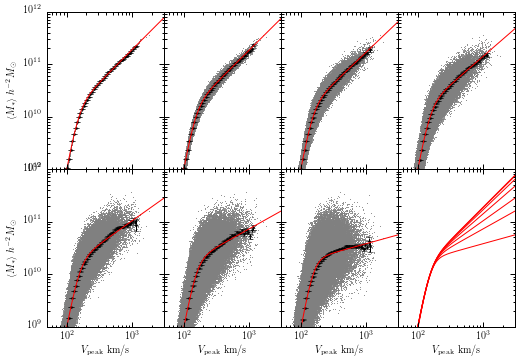

In [14]:
"""
plot the SMHM relations and fits
"""

msample = np.logspace(1.0,3.5,1000)

fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(10.0, 5.0))
fig.subplots_adjust(hspace=0, wspace=0, left=0.2, right=0.85, bottom=0.05, top=0.925)
axes = axes.flatten()

ax = axes[0]
ax.plot(mock_2_00['halo_vpeak'], mock_2_00['stellar_mass'], '.', color='grey', ms=1)
ax.errorbar(10**bin_centers, 10**mean_y_00, yerr= lin_err_00, fmt='o', ms=2, color='black')
ax.plot(msample, smhm_model_00(msample), color='red')
ax.set_ylabel(r'$\langle M_{*}\rangle~h^{-2}M_{\odot}$')
ax.set_ylim([10**9.0,10**12.0])
ax.set_xlim([50,3000])
ax.set_xscale('log')
ax.set_yscale('log')

ax = axes[1]
ax.plot(mock_2_05['halo_vpeak'], mock_2_05['stellar_mass'], '.', color='grey', ms=1)
ax.errorbar(10**bin_centers, 10**mean_y_05, yerr= lin_err_05, fmt='o', ms=2, color='black')
ax.plot(msample, smhm_model_05(msample), color='red')
ax.set_ylim([10**9.0,10**12.0])
ax.set_xlim([50,3000])
ax.set_xscale('log')
ax.set_yscale('log')

ax = axes[2]
ax.plot(mock_2_10['halo_vpeak'], mock_2_10['stellar_mass'], '.', color='grey', ms=1)
ax.errorbar(10**bin_centers, 10**mean_y_10, yerr= lin_err_10, fmt='o', ms=2, color='black')
ax.plot(msample, smhm_model_10(msample), color='red')
ax.set_ylim([10**9.0,10**12.0])
ax.set_xlim([10**10,10**15])
ax.set_xscale('log')
ax.set_yscale('log')

ax = axes[3]
ax.plot(mock_2_15['halo_vpeak'], mock_2_15['stellar_mass'], '.', color='grey', ms=1)
ax.errorbar(10**bin_centers, 10**mean_y_15, yerr= lin_err_15, fmt='o', ms=2, color='black')
ax.plot(msample, smhm_model_15(msample), color='red')
ax.set_ylim([10**9.0,10**12.0])
ax.set_xlim([50,3000])
ax.set_xscale('log')
ax.set_yscale('log')

ax = axes[4]
ax.plot(mock_2_00['halo_vpeak'], mock_2_20['stellar_mass'], '.', color='grey', ms=1)
ax.errorbar(10**bin_centers, 10**mean_y_20, yerr= lin_err_20, fmt='o', ms=2, color='black')
ax.plot(msample, smhm_model_20(msample), color='red')
ax.set_ylabel(r'$\langle M_{*}\rangle~h^{-2}M_{\odot}$')
ax.set_xlabel(r'$V_{\rm peak}~{\rm km/s}$')
ax.set_ylim([10**9.0,10**12.0])
ax.set_xlim([50,3000])
ax.set_xscale('log')
ax.set_yscale('log')

ax = axes[5]
ax.plot(mock_2_25['halo_vpeak'], mock_2_25['stellar_mass'], '.', color='grey', ms=1)
ax.errorbar(10**bin_centers, 10**mean_y_25, yerr= lin_err_25, fmt='o', ms=2, color='black')
ax.plot(msample, smhm_model_25(msample), color='red')
ax.set_xlabel(r'$V_{\rm peak}~{\rm km/s}$')
ax.set_ylim([10**9.0,10**12.0])
ax.set_xlim([50,3000])
ax.set_xscale('log')
ax.set_yscale('log')

ax = axes[6]
ax.plot(mock_2_30['halo_vpeak'], mock_2_30['stellar_mass'], '.', color='grey', ms=1)
ax.errorbar(10**bin_centers, 10**mean_y_30, yerr= lin_err_30, fmt='o', ms=2, color='black')
ax.plot(msample, smhm_model_30(msample), color='red')
ax.set_xlabel(r'$V_{\rm peak}~{\rm km/s}$')
ax.set_ylim([10**9.0,10**12.0])
ax.set_xlim([50,3000])
ax.set_xscale('log')
ax.set_yscale('log')

ax = axes[7]
ax.plot(msample, smhm_model_00(msample), color='red')
ax.plot(msample, smhm_model_05(msample), color='red')
ax.plot(msample, smhm_model_10(msample), color='red')
ax.plot(msample, smhm_model_15(msample), color='red')
ax.plot(msample, smhm_model_20(msample), color='red')
ax.plot(msample, smhm_model_25(msample), color='red')
ax.plot(msample, smhm_model_30(msample), color='red')
ax.set_ylim([10**9.0,10**12.0])
ax.set_xlim([50,3000])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$V_{\rm peak}~{\rm km/s}$')
plt.show()

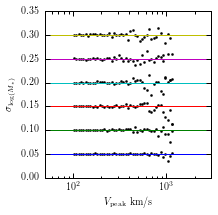

In [15]:
fig = plt.figure(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.errorbar(10**bin_centers, std_y_05, fmt='o', ms=2, color='black')
plt.plot([50,3000],[0.05,0.05],'-')
plt.errorbar(10**bin_centers, std_y_10, fmt='o', ms=2, color='black')
plt.plot([50,3000],[0.1,0.1],'-')
plt.errorbar(10**bin_centers, std_y_15, fmt='o', ms=2, color='black')
plt.plot([50,3000],[0.15,0.15],'-')
plt.errorbar(10**bin_centers, std_y_20, fmt='o', ms=2, color='black')
plt.plot([50,3000],[0.2,0.2],'-')
plt.errorbar(10**bin_centers, std_y_25, fmt='o', ms=2, color='black')
plt.plot([50,3000],[0.25,0.25],'-')
plt.errorbar(10**bin_centers, std_y_30, fmt='o', ms=2, color='black')
plt.plot([50,3000],[0.3,0.30],'-')
plt.xlim([50,3000])
plt.xscale('log')
plt.xlabel(r'$V_{\rm peak}~{\rm km/s}$')
plt.ylabel(r'$\sigma_{\log(M_*)}$')
plt.show()

In [16]:
sigmas = np.array([0,0.05,0.1,0.15,0.2,0.25,0.3])
y0s = np.array([popt_00[0],popt_05[0],popt_10[0],popt_15[0],popt_20[0],popt_25[0],popt_30[0]])
x0s = np.array([popt_00[1],popt_05[1],popt_10[1],popt_15[1],popt_20[1],popt_25[1],popt_30[1]])
alphas = np.array([popt_00[2],popt_05[2],popt_10[2],popt_15[2],popt_20[2],popt_25[2],popt_30[2]])
betas = np.array([popt_00[3],popt_05[3],popt_10[3],popt_15[3],popt_20[3],popt_25[3],popt_30[3]])

y0s_err = np.array([param_err_00[0],param_err_05[0],param_err_10[0],param_err_15[0],param_err_20[0],param_err_25[0],param_err_30[0]])
x0s_err = np.array([param_err_00[1],param_err_05[1],param_err_10[1],param_err_15[1],param_err_20[1],param_err_25[1],param_err_30[1]])
alphas_err  = np.array([param_err_00[2],param_err_05[2],param_err_10[2],param_err_15[2],param_err_20[2],param_err_25[2],param_err_30[2]])
betas_err  = np.array([param_err_00[3],param_err_05[3],param_err_10[3],param_err_15[3],param_err_20[3],param_err_25[3],param_err_30[3]])

x0 = 1.68168482688 +- 1.23559775126
alpha = 1.60038362488 +- 0.670706416977
b = 8.94230852095 +- 0.00689847964488
 


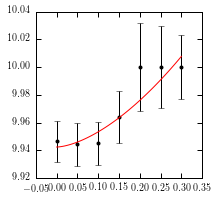

In [17]:
def exp_model(x, x0=0.5, alpha=1.5, b=-1.2, a=1.0):
    return a*np.exp((x/x0)**alpha) + b

popt_1, cov = curve_fit(exp_model, sigmas, y0s, sigma=y0s_err, p0=[0.5,1.5,10.0])
param_err = np.sqrt(cov.diagonal())
print('x0 = {0} +- {1}'.format(popt_1[0],param_err[0]))
print('alpha = {0} +- {1}'.format(popt_1[1],param_err[1]))
print('b = {0} +- {1}'.format(popt_1[2],param_err[2]))
#print('a = {0} +- {1}'.format(popt[3],param_err[3]))
print(' ')

y0_model = lambda x: exp_model(x, *popt_1)

x_sample = np.linspace(0,0.3,100)

fig = plt.figure(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.errorbar(sigmas, y0s, yerr=y0s_err, fmt='o', mec='none', color='black', ms=4)
plt.plot(x_sample, y0_model(x_sample), '-', color='red')
plt.xlim([-0.05,0.35])
plt.show()

x0 = 3.64275425 +- 3.78565496472
alpha = 1.54658495991 +- 0.628495561851
b = 1.17641517163 +- 0.00213631611105
 


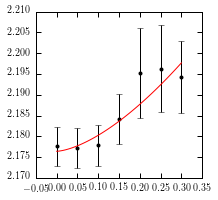

In [18]:
def exp_model(x, x0=0.5, alpha=1.5, b=-1.2, a=1.0):
    return a*np.exp((x/x0)**alpha) + b

popt_2, cov = curve_fit(exp_model, sigmas, x0s, sigma=x0s_err, p0=[0.5,1.5,2.0])
param_err = np.sqrt(cov.diagonal())
print('x0 = {0} +- {1}'.format(popt_2[0],param_err[0]))
print('alpha = {0} +- {1}'.format(popt_2[1],param_err[1]))
print('b = {0} +- {1}'.format(popt_2[2],param_err[2]))
#print('a = {0} +- {1}'.format(popt[3],param_err[3]))
print(' ')

x0_model = lambda x: exp_model(x, *popt_2)

x_sample = np.linspace(0,0.3,100)

fig = plt.figure(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.errorbar(sigmas, x0s, yerr=x0s_err, fmt='o', mec='none', color='black', ms=4)
plt.plot(x_sample, x0_model(x_sample), '-', color='red')
plt.xlim([-0.05,0.35])
plt.show()

x0 = 1.79334260437 +- 4.48143720394
alpha = 0.969444629316 +- 1.24000081479
b = -6.96854600361 +- 0.0698321572574
 


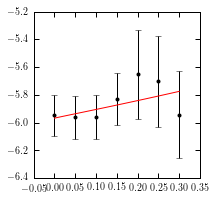

In [19]:
def exp_model(x, x0=0.5, alpha=1.5, b=-1.2, a=1.0):
    return a*np.exp((x/x0)**alpha) + b

popt_3, cov = curve_fit(exp_model, sigmas, alphas, sigma=alphas_err, p0=[0.5,1.5,-4.5])
param_err = np.sqrt(cov.diagonal())
print('x0 = {0} +- {1}'.format(popt_3[0],param_err[0]))
print('alpha = {0} +- {1}'.format(popt_3[1],param_err[1]))
print('b = {0} +- {1}'.format(popt_3[2],param_err[2]))
#print('a = {0} +- {1}'.format(popt[3],param_err[3]))
print(' ')

alpha_model = lambda x: exp_model(x, *popt_3)

x_sample = np.linspace(0,0.3,100)

fig = plt.figure(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.errorbar(sigmas, alphas, yerr=alphas_err, fmt='o', mec='none', color='black', ms=4)
plt.plot(x_sample, alpha_model(x_sample), '-', color='red')
plt.xlim([-0.05,0.35])
plt.show()

x0 = 0.371321625684 +- 0.00497218972179
alpha = 2.01642429227 +- 0.0908656256331
b = -1.26083349077 +- 0.00714962653781
 


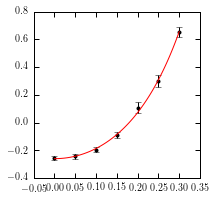

In [20]:
def exp_model(x, x0=0.5, alpha=1.5, b=-1.2, a=1.0):
    return a*np.exp((x/x0)**alpha) + b

popt_4, cov = curve_fit(exp_model, sigmas, betas, sigma=betas_err, p0=[0.5,1.5,-1.2])
param_err = np.sqrt(cov.diagonal())
print('x0 = {0} +- {1}'.format(popt_4[0],param_err[0]))
print('alpha = {0} +- {1}'.format(popt_4[1],param_err[1]))
print('b = {0} +- {1}'.format(popt_4[2],param_err[2]))
#print('a = {0} +- {1}'.format(popt[3],param_err[3]))
print(' ')

beta_model = lambda x: exp_model(x, *popt_4)

x_sample = np.linspace(0,0.3,100)

fig = plt.figure(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.errorbar(sigmas, betas, yerr=betas_err, fmt='o', mec='none', color='black', ms=4)
plt.plot(x_sample, beta_model(x_sample), '-', color='red')
plt.xlim([-0.05,0.35])
plt.show()

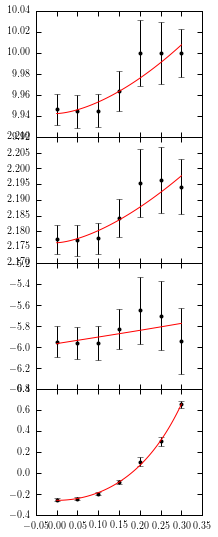

In [21]:
fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(3.3, 10.0))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.1, top=0.95, hspace=0.0)

#top panel
ax=axes[0]
ax.errorbar(sigmas, y0s, yerr=y0s_err, fmt='o', mec='none', color='black', ms=4)
ax.plot(x_sample, y0_model(x_sample), '-', color='red')
ax.set_xlim([-0.05,0.35])

#upper middle
ax=axes[1]
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
ax.errorbar(sigmas, x0s, yerr=x0s_err, fmt='o', mec='none', color='black', ms=4)
ax.plot(x_sample, x0_model(x_sample), '-', color='red')
ax.set_xlim([-0.05,0.35])

#lower middle
ax=axes[2]
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
ax.errorbar(sigmas, alphas, yerr=alphas_err, fmt='o', mec='none', color='black', ms=4)
ax.plot(x_sample, alpha_model(x_sample), '-', color='red')
ax.set_xlim([-0.05,0.35])

#bottom panel
ax=axes[3]
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
ax.errorbar(sigmas, betas, yerr=betas_err, fmt='o', mec='none', color='black', ms=4)
ax.plot(x_sample, beta_model(x_sample), '-', color='red')
ax.set_xlim([-0.05,0.35])

plt.show()

In [22]:
from SHAM_model_components import ParamSmHm
smhm = ParamSmHm(prim_haloprop_key='halo_vpeak', scatter=0.0)

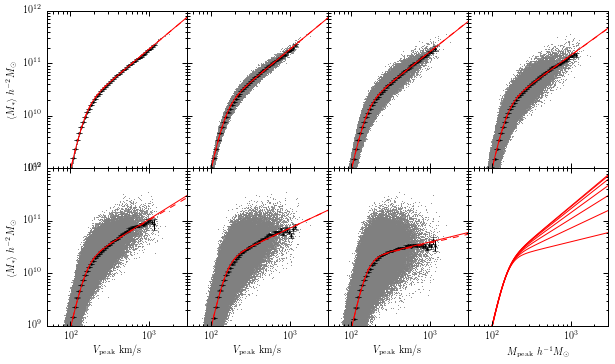

In [23]:
"""
plot the SMVP relations and fits
"""

msample = np.logspace(1.0,3.5,1000)

fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(12.0, 5.0))
fig.subplots_adjust(hspace=0, wspace=0, left=0.2, right=0.85, bottom=0.05, top=0.925)
axes = axes.flatten()

ax = axes[0]
ax.plot(mock_2_00['halo_vpeak'], mock_2_00['stellar_mass'], '.', color='grey', ms=1)
ax.errorbar(10**bin_centers, 10**mean_y_00, yerr= lin_err_00, fmt='o', ms=2, color='black')
ax.plot(msample, smhm_model_00(msample), '--', color='red')
smhm = ParamSmHm(prim_haloprop_key='halo_vpeak', log_scatter=0.0)
ax.plot(msample, smhm.mean_stellar_mass(prim_haloprop=msample), '-', color='red')
ax.set_ylabel(r'$\langle M_{*}\rangle~h^{-2}M_{\odot}$')
ax.set_ylim([10**9.0,10**12.0])
ax.set_xlim([50,3000])
ax.set_xscale('log')
ax.set_yscale('log')

ax = axes[1]
ax.plot(mock_2_05['halo_vpeak'], mock_2_05['stellar_mass'], '.', color='grey', ms=1)
ax.errorbar(10**bin_centers, 10**mean_y_05, yerr= lin_err_05, fmt='o', ms=2, color='black')
ax.plot(msample, smhm_model_05(msample), '--', color='red')
smhm = ParamSmHm(prim_haloprop_key='halo_vpeak', log_scatter=0.05)
ax.plot(msample, smhm.mean_stellar_mass(prim_haloprop=msample), '-', color='red')
ax.set_ylim([10**9.0,10**12.0])
ax.set_xlim([50,3000])
ax.set_xscale('log')
ax.set_yscale('log')

ax = axes[2]
ax.plot(mock_2_10['halo_vpeak'], mock_2_10['stellar_mass'], '.', color='grey', ms=1)
ax.errorbar(10**bin_centers, 10**mean_y_10, yerr= lin_err_10, fmt='o', ms=2, color='black')
ax.plot(msample, smhm_model_10(msample), '--', color='red')
smhm = ParamSmHm(prim_haloprop_key='halo_vpeak', log_scatter=0.1)
ax.plot(msample, smhm.mean_stellar_mass(prim_haloprop=msample), '-', color='red')
ax.set_ylim([10**9.0,10**12.0])
ax.set_xlim([10**10,10**15])
ax.set_xscale('log')
ax.set_yscale('log')

ax = axes[3]
ax.plot(mock_2_15['halo_vpeak'], mock_2_15['stellar_mass'], '.', color='grey', ms=1)
ax.errorbar(10**bin_centers, 10**mean_y_15, yerr= lin_err_15, fmt='o', ms=2, color='black')
ax.plot(msample, smhm_model_15(msample), '--',  color='red')
smhm = ParamSmHm(prim_haloprop_key='halo_vpeak', log_scatter=0.15)
ax.plot(msample, smhm.mean_stellar_mass(prim_haloprop=msample), '-', color='red')
ax.set_ylim([10**9.0,10**12.0])
ax.set_xlim([50,3000])
ax.set_xscale('log')
ax.set_yscale('log')

ax = axes[4]
ax.plot(mock_2_00['halo_vpeak'], mock_2_20['stellar_mass'], '.', color='grey', ms=1)
ax.errorbar(10**bin_centers, 10**mean_y_20, yerr= lin_err_20, fmt='o', ms=2, color='black')
ax.plot(msample, smhm_model_20(msample), '--', color='red')
smhm = ParamSmHm(prim_haloprop_key='halo_vpeak', log_scatter=0.2)
ax.plot(msample, smhm.mean_stellar_mass(prim_haloprop=msample), '-', color='red')
ax.set_ylabel(r'$\langle M_{*}\rangle~h^{-2}M_{\odot}$')
ax.set_xlabel(r'$V_{\rm peak}~{\rm km/s}$')
ax.set_ylim([10**9.0,10**12.0])
ax.set_xlim([50,3000])
ax.set_xscale('log')
ax.set_yscale('log')

ax = axes[5]
ax.plot(mock_2_25['halo_vpeak'], mock_2_25['stellar_mass'], '.', color='grey', ms=1)
ax.errorbar(10**bin_centers, 10**mean_y_25, yerr= lin_err_25, fmt='o', ms=2, color='black')
ax.plot(msample, smhm_model_25(msample), '--', color='red')
smhm = ParamSmHm(prim_haloprop_key='halo_vpeak', log_scatter=0.25)
ax.plot(msample, smhm.mean_stellar_mass(prim_haloprop=msample), '-', color='red')
ax.set_xlabel(r'$V_{\rm peak}~{\rm km/s}$')
ax.set_ylim([10**9.0,10**12.0])
ax.set_xlim([50,3000])
ax.set_xscale('log')
ax.set_yscale('log')

ax = axes[6]
ax.plot(mock_2_30['halo_vpeak'], mock_2_30['stellar_mass'], '.', color='grey', ms=1)
ax.errorbar(10**bin_centers, 10**mean_y_30, yerr= lin_err_30, fmt='o', ms=2, color='black')
ax.plot(msample, smhm_model_30(msample), '--', color='red')
smhm = ParamSmHm(prim_haloprop_key='halo_vpeak', log_scatter=0.3)
ax.plot(msample, smhm.mean_stellar_mass(prim_haloprop=msample), '-', color='red')
ax.set_xlabel(r'$V_{\rm peak}~{\rm km/s}$')
ax.set_ylim([10**9.0,10**12.0])
ax.set_xlim([50,3000])
ax.set_xscale('log')
ax.set_yscale('log')

ax = axes[7]
smhm = ParamSmHm(prim_haloprop_key='halo_vpeak', log_scatter=0.0)
ax.plot(msample, smhm.mean_stellar_mass(prim_haloprop=msample), '-', color='red')
smhm = ParamSmHm(prim_haloprop_key='halo_vpeak', log_scatter=0.05)
ax.plot(msample, smhm.mean_stellar_mass(prim_haloprop=msample), '-', color='red')
smhm = ParamSmHm(prim_haloprop_key='halo_vpeak', log_scatter=0.1)
ax.plot(msample, smhm.mean_stellar_mass(prim_haloprop=msample), '-', color='red')
smhm = ParamSmHm(prim_haloprop_key='halo_vpeak', log_scatter=0.15)
ax.plot(msample, smhm.mean_stellar_mass(prim_haloprop=msample), '-', color='red')
smhm = ParamSmHm(prim_haloprop_key='halo_vpeak', log_scatter=0.2)
ax.plot(msample, smhm.mean_stellar_mass(prim_haloprop=msample), '-', color='red')
smhm = ParamSmHm(prim_haloprop_key='halo_vpeak', log_scatter=0.25)
ax.plot(msample, smhm.mean_stellar_mass(prim_haloprop=msample), '-', color='red')
smhm = ParamSmHm(prim_haloprop_key='halo_vpeak', log_scatter=0.3)
ax.plot(msample, smhm.mean_stellar_mass(prim_haloprop=msample), '-', color='red')
ax.set_ylim([10**9.0,10**12.0])
ax.set_xlim([50,3000])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$M_{\rm peak}~h^{-1}M_{\odot}$')

plt.show()